https://machinelearningmastery.com/how-to-develop-a-word-level-neural-language-model-in-keras/

In [ ]:
%tensorflow_version 1.1

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.1`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [ ]:

import numpy as np
import pandas as pd
from numpy import array
from collections import defaultdict
import re

from bs4 import BeautifulSoup

import sys
import os
import string
os.environ['KERAS_BACKEND']='tensorflow'

from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, LSTM, GRU, Bidirectional, TimeDistributed
from keras.models import Model, Sequential

from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras import initializers

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
from pickle import dump



Using TensorFlow backend.


In [ ]:
def gpu_alloc(device_id):
    os.environ["CUDA_VISIBLE_DEVICES"]=device_id
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    set_session(tf.Session(config=config))

In [ ]:
gpu_alloc("1")

# NLM
https://machinelearningmastery.com/how-to-develop-a-word-level-neural-language-model-in-keras/

# Data


In [ ]:
!wget https://raw.githubusercontent.com/mayank2498/The-Republic-language-model/master/republic_cleaned.txt

--2020-07-15 13:07:56--  https://raw.githubusercontent.com/mayank2498/The-Republic-language-model/master/republic_cleaned.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 657816 (642K) [text/plain]
Saving to: ‘republic_cleaned.txt’

republic_cleaned.tx 100%[===================>] 642.40K  --.-KB/s    in 0.08s   

2020-07-15 13:07:57 (7.83 MB/s) - ‘republic_cleaned.txt’ saved [657816/657816]



In [ ]:
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

# turn a doc into clean tokens
def clean_doc(doc):
    # replace '--' with a space ' '
    doc = doc.replace('--', ' ')
    # split into tokens by white space
    tokens = doc.split()
    # remove punctuation from each token
    table = str.maketrans('', '', string.punctuation)
    tokens = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # make lower case
    tokens = [word.lower() for word in tokens]
    return tokens

# save tokens to file, one dialog per line
def save_doc(lines, filename):
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

# load document
in_filename = 'republic_cleaned.txt'
doc = load_doc(in_filename)
print(doc[:200])

# clean document
tokens = clean_doc(doc)
print(tokens[:200])
print('Total Tokens: %d' % len(tokens))
print('Unique Tokens: %d' % len(set(tokens)))

# organize into sequences of tokens
length = 50 + 1
sequences = list()
for i in range(length, len(tokens)):
    # select sequence of tokens
    seq = tokens[i-length:i]
    # convert into a line
    line = ' '.join(seq)
    # store
    sequences.append(line)
print('Total Sequences: %d' % len(sequences))

# save sequences to file
out_filename = 'republic_sequences.txt'
save_doc(sequences, out_filename)

﻿I went down yesterday to the Piraeus with Glaucon the son of Ariston,
that I might offer up my prayers to the goddess (Bendis, the Thracian
Artemis.); and also because I wanted to see in what manner 
['went', 'down', 'yesterday', 'to', 'the', 'piraeus', 'with', 'glaucon', 'the', 'son', 'of', 'ariston', 'that', 'i', 'might', 'offer', 'up', 'my', 'prayers', 'to', 'the', 'goddess', 'bendis', 'the', 'thracian', 'artemis', 'and', 'also', 'because', 'i', 'wanted', 'to', 'see', 'in', 'what', 'manner', 'they', 'would', 'celebrate', 'the', 'festival', 'which', 'was', 'a', 'new', 'thing', 'i', 'was', 'delighted', 'with', 'the', 'procession', 'of', 'the', 'inhabitants', 'but', 'that', 'of', 'the', 'thracians', 'was', 'equally', 'if', 'not', 'more', 'beautiful', 'when', 'we', 'had', 'finished', 'our', 'prayers', 'and', 'viewed', 'the', 'spectacle', 'we', 'turned', 'in', 'the', 'direction', 'of', 'the', 'city', 'and', 'at', 'that', 'instant', 'polemarchus', 'the', 'son', 'of', 'cephalus', 'chanced

## Train LM

In [ ]:
# load
in_filename = 'republic_sequences.txt'
doc = load_doc(in_filename)
lines = doc.split('\n')

# integer encode sequences of words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(lines)
sequences = tokenizer.texts_to_sequences(lines)
# vocabulary size
vocab_size = len(tokenizer.word_index) + 1

# separate into input and output
sequences = array(sequences)
X, y = sequences[:,:-1], sequences[:,-1]
y = to_categorical(y, num_classes=vocab_size)
seq_length = X.shape[1]

# define model
model = Sequential()
model.add(Embedding(vocab_size, 50, input_length=seq_length))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100))
model.add(Dense(100, activation='relu'))
model.add(Dense(vocab_size, activation='softmax'))
print(model.summary())




Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 50)            370500    
_________________________________________________________________
lstm_1 (LSTM)                (None, 50, 100)           60400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 7410)              748410    
Total params: 1,269,810
Trainable params: 1,269,810
Non-trainable params: 0
_________________________________________________________________
None


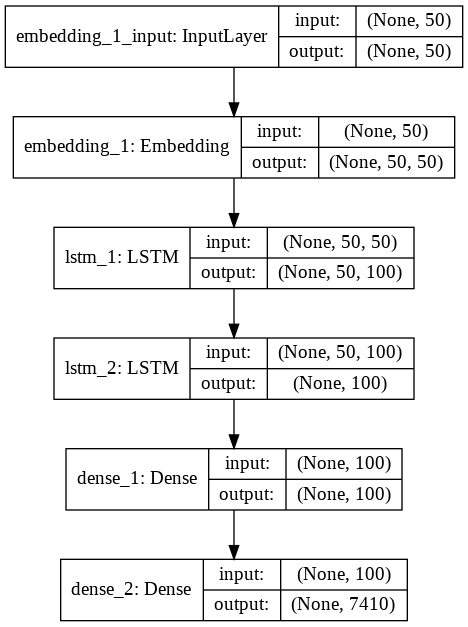

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
# compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit model
model.fit(X, y, batch_size=128, epochs=100)


Epoch 1/100
118630/118630 [==============================] - 326s 3ms/step - loss: 6.1599 - accuracy: 0.0703
Epoch 2/100
118630/118630 [==============================] - 328s 3ms/step - loss: 5.7024 - accuracy: 0.1040
Epoch 3/100
118630/118630 [==============================] - 322s 3ms/step - loss: 5.4600 - accuracy: 0.1284
Epoch 4/100
118630/118630 [==============================] - 321s 3ms/step - loss: 5.2988 - accuracy: 0.1431
Epoch 5/100
118630/118630 [==============================] - 334s 3ms/step - loss: 5.1828 - accuracy: 0.1537
Epoch 6/100
118630/118630 [==============================] - 332s 3ms/step - loss: 5.0847 - accuracy: 0.1597
Epoch 7/100
118630/118630 [==============================] - 320s 3ms/step - loss: 4.9962 - accuracy: 0.1661
Epoch 8/100
118630/118630 [==============================] - 322s 3ms/step - loss: 4.9150 - accuracy: 0.1705
Epoch 9/100
118630/118630 [==============================] - 334s 3ms/step - loss: 4.8400 - accuracy: 0.1745
Epoch 10/100
11863

In [ ]:
# save the model to file
model.save('model.h5')
# save the tokenizer
dump(tokenizer, open('tokenizer.pkl', 'wb'))

## Use LM

Generate Text
The first step in generating text is preparing a seed input.

We will select a random line of text from the input text for this purpose. Once selected, we will print it so that we have some idea of what was used.
```
# select a seed text
seed_text = lines[randint(0,len(lines))]
print(seed_text + '\n')


```
Next, we can generate new words, one at a time.

First, the seed text must be encoded to integers using the same tokenizer that we used when training the model.
```
encoded = tokenizer.texts_to_sequences([seed_text])[0]
```
The model can predict the next word directly by calling model.predict_classes() that will return the index of the word with the highest probability.
```
# predict probabilities for each word
yhat = model.predict_classes(encoded, verbose=0)
```
We can then look up the index in the Tokenizers mapping to get the associated word.
```
out_word = ''
for word, index in tokenizer.word_index.items():
	if index == yhat:
		out_word = word
		break
```
We can then append this word to the seed text and repeat the process.

Importantly, the input sequence is going to get too long. We can truncate it to the desired length after the input sequence has been encoded to integers. Keras provides the pad_sequences() function that we can use to perform this truncation.
```
encoded = pad_sequences([encoded], maxlen=seq_length, truncating='pre')
```
We can wrap all of this into a function called generate_seq() that takes as input the model, the tokenizer, input sequence length, the seed text, and the number of words to generate. It then returns a sequence of words generated by the model.
```
# generate a sequence from a language model
def generate_seq(model, tokenizer, seq_length, seed_text, n_words):
	result = list()
	in_text = seed_text
	# generate a fixed number of words
	for _ in range(n_words):
		# encode the text as integer
		encoded = tokenizer.texts_to_sequences([in_text])[0]
		# truncate sequences to a fixed length
		encoded = pad_sequences([encoded], maxlen=seq_length, truncating='pre')
		# predict probabilities for each word
		yhat = model.predict_classes(encoded, verbose=0)
		# map predicted word index to word
		out_word = ''
		for word, index in tokenizer.word_index.items():
			if index == yhat:
				out_word = word
				break
		# append to input
		in_text += ' ' + out_word
		result.append(out_word)
	return ' '.join(result)
```

In [ ]:
# Use LM
from random import randint
from pickle import load
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences


# generate a sequence from a language model
def generate_seq(model, tokenizer, seq_length, seed_text, n_words):
    result = list()
    in_text = seed_text
    # generate a fixed number of words
    for _ in range(n_words):
        # encode the text as integer
        encoded = tokenizer.texts_to_sequences([in_text])[0]
        # truncate sequences to a fixed length
        encoded = pad_sequences([encoded], maxlen=seq_length, truncating='pre')
        # predict probabilities for each word
        yhat = model.predict_classes(encoded, verbose=0)
        # map predicted word index to word
        out_word = ''
        for word, index in tokenizer.word_index.items():
            if index == yhat:
                out_word = word
                break
        # append to input
        in_text += ' ' + out_word
        result.append(out_word)
    return ' '.join(result)

# load cleaned text sequences
in_filename = 'republic_sequences.txt'
doc = load_doc(in_filename)
lines = doc.split('\n')
seq_length = len(lines[0].split()) - 1

# load the model
model = load_model('model.h5')

# load the tokenizer
tokenizer = load(open('tokenizer.pkl', 'rb'))

# select a seed text
seed_text = lines[randint(0,len(lines))]
print(seed_text + '\n')

# generate new text
generated = generate_seq(model, tokenizer, seq_length, seed_text, 50)
print(generated)

be full of spirit yes but are not these spirited natures apt to be savage with one another and with everybody else a difficulty by no means easy to overcome he replied whereas i said they ought to be dangerous to their enemies and gentle to their friends if not they

know whether we shall be able to have been schooled by trial which is the sequel of the other state and the other smaller than the other and the other and the other and the other and the other passes within him which is the strings in which the same
